# Motion Primitive Library Optimization

A first naive implementation of the trajectory generation was to generate a lot of motion primitives (MP), attribute a cost to each one, then select the one with the optimal cost.

We do not need to execute the cost function on the entire library if we can find a way to smartly select MP to evaluate. Thus, we may be able to save computation time.

In this notebook, we try to look at the cost function, to see how it may be optimized.

We collect data of MPL over a sampled space of final states with the constraints $z=Cste$, $\theta = [\theta_0 - \pi/2; \theta_0 + \pi/2]$ and $||v|| = [min(v_0 - 4/T_f, 0.1); v_0 + 0.5/T_f]$.
We also set $T_f = 1.5$.
We use the MAVROS, PX4, Gazebo simulation environment, with the Iris UAV.
The world is `test_zone`.
The data format is `data[i, j, :]` for the i-th MPL iteration, j-th MP in the library. The last axis is split between all the data collected for one MP: `data[i,j,:] = [...pos0, ...vel0, ...acc0, ...posf, ...velf, ...accf, cost]`.

We did two experiments.
The first experiment data is in `mpls1.npy`. The start point is `[0, 0, 1]` and the end point is `[5, -7.5, 1]`.
The path is mainly a straight line.

The second experiment data is in `mpls2.npy`. The start point is `[5, 0, 1]` and the end point is `[-5, -7.5, 1]`.
The path is an S shape and goes close to an obstacle at the end. The goal here is to see how the algorithm would react to obstacles in the path.

In [116]:
import pickle, numpy as np, matplotlib.pyplot as plt
X0, Y0, Z0, VX0, VY0, VZ0, AX0, AY0, AZ0, XF, YF, ZF, VXF, VYF, VZF, AXF, AYF, AZF, COST = np.arange(19)
get_yaw = lambda t: np.arctan2(t[VYF], t[VXF])
get_vnorm = lambda t: np.linalg.norm(t[VXF:VZF+1])
lerp = lambda a, b, t: np.array(a) * (1-t) + np.array(b) * t

In [183]:
def lift(angles, offset=0):
  out = np.zeros(angles.shape)
  for i, angle in enumerate(angles):
    if angle + offset >= np.pi:
      out[i] = angle + offset - 2 * np.pi
    elif angle + offset <= -np.pi:
      out[i] = angle + offset + 2 * np.pi
    else:
      out[i] = angle + offset
  return out

In [184]:
data1, data2 = np.load('mpls1.npy'), np.load('mpls2.npy')

In [228]:
def get_norms(mpl):
  # Find all possible norms
  norms = np.zeros(mpl.shape[0])
  for i, t in enumerate(mpl):
    norms[i] = get_vnorm(t)
  # plt.scatter(np.arange(len(norms)), norms)
  norms = norms[0:15]
  return norms

def get_yaws(mpl):
  yaw = np.zeros(mpl[::15].shape[0])
  for i, t in enumerate(mpl[::15]):
    yaw[i] = get_yaw(t)
  return yaw

Text(0.5, 1.0, 'Cost of each MP relative to their final yaw angle')

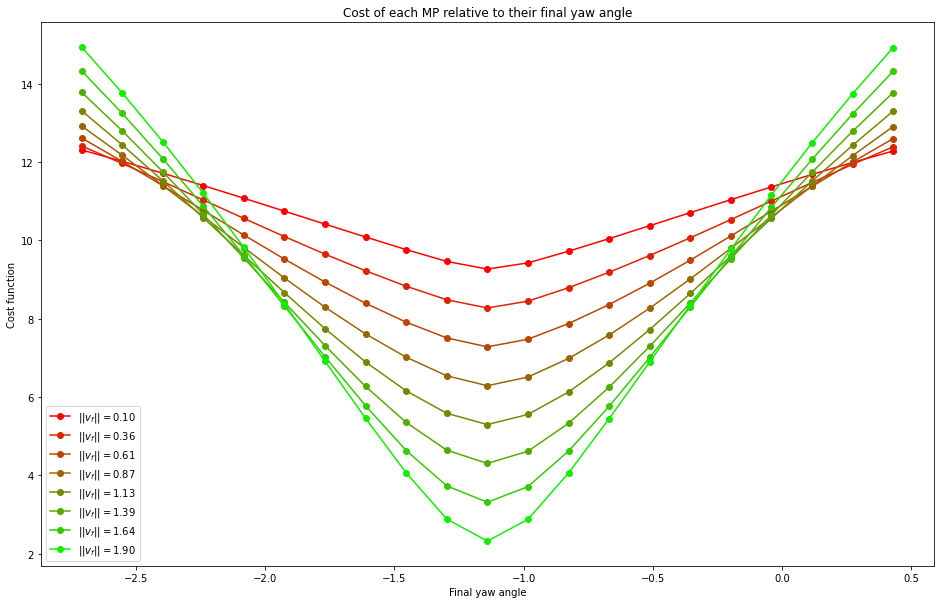

In [249]:
mpl = data1[3]
# Plot along the yaw axis
plt.figure(figsize=(16,10))
yaw = get_yaws(mpl)
norms = get_norms(mpl)
for offset in range(0, 15, 2):
  plt.plot(yaw, mpl[offset::15, COST], 'o-', label='$||v_f|| = {:.2f}$'.format(norms[offset]), color=lerp((1,0,0),(0,1,0),offset/15))
plt.legend()
plt.ylabel('Cost function')
plt.xlabel('Final yaw angle')
plt.title('Cost of each MP relative to their final yaw angle')

Text(0.5, 1.0, 'Cost of each MP relative to their final yaw angle, where some MP collide with an obstacle')

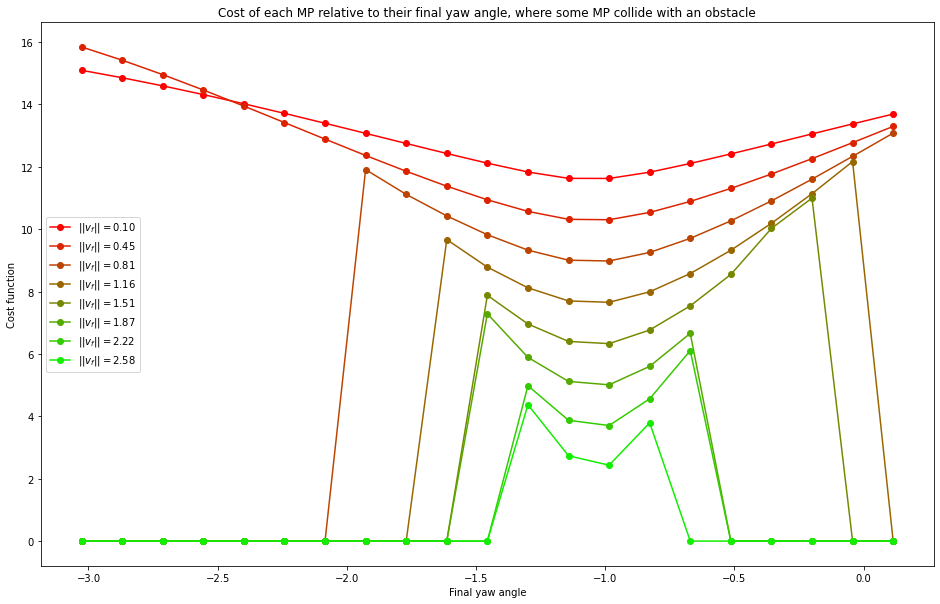

In [231]:
mpl = data2[7]
# Plot along the yaw axis
plt.figure(figsize=(16,10))
yaw = get_yaws(mpl)
yaw = lift(yaw, 2)
norms = get_norms(mpl)
for offset in range(0, 15, 2):
  plt.plot(yaw, [(v if v < 1000 else 0) for v in mpl[offset::15, COST]], 'o-', label='$||v_f|| = {:.2f}$'.format(norms[offset]), color=lerp((1,0,0),(0,1,0),offset/15))
plt.legend()
plt.ylabel('MP Cost')
plt.xlabel('Final yaw angle')
plt.title('Cost of each MP relative to their final yaw angle, where some MP collide with an obstacle')

**Hypothesis:** We can find the min in $\theta_f$, then find the min in $||v_f||$, and the min obtained should be the global min.

Text(0.5, 0, 'Final velocity norm')

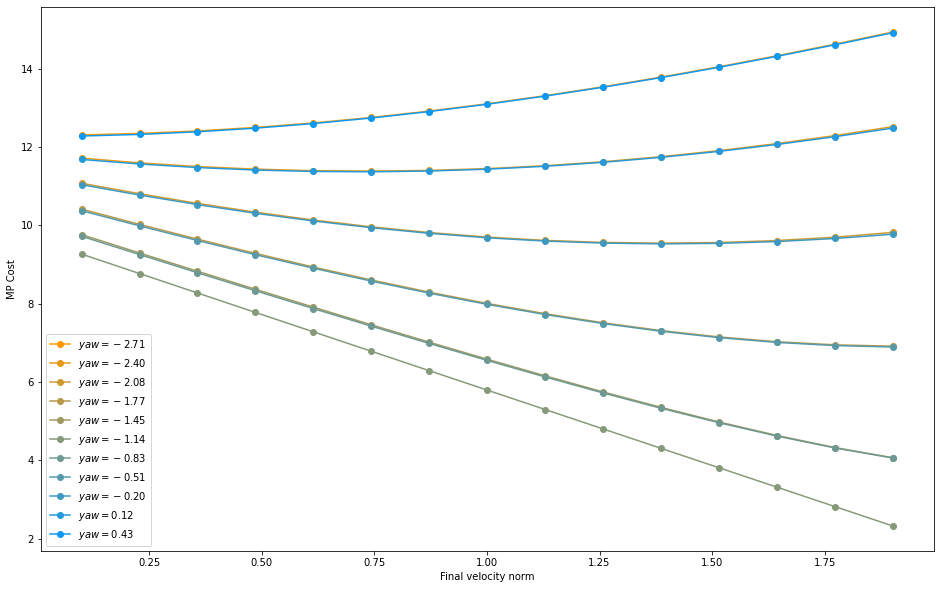

In [267]:
mpl = data1[3]
norms = get_norms(mpl)
n = mpl.shape[0] // len(norms)
plt.figure(figsize=(16,10))
for i in range(0, n, 2):
  plt.plot(norms, mpl[i*15:(i+1)*15, COST], 'o-', label='$yaw = {:1.2f}$'.format(get_yaw(mpl[i*15])), color=lerp((1,.6,0),(0,.6,1),i/n))
plt.legend()
plt.ylabel('MP Cost')
plt.xlabel('Final velocity norm')

Text(0.5, 0, 'Final velocity norm')

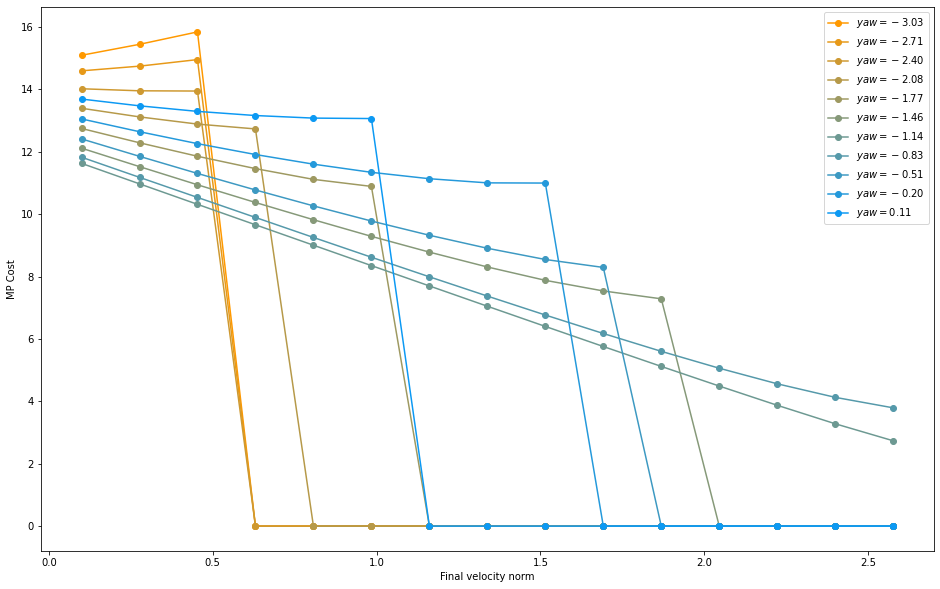

In [269]:
mpl = data2[7]
norms = get_norms(mpl)
yaw = get_yaws(mpl)
yaw = lift(yaw, 2)
n = mpl.shape[0] // len(norms)
plt.figure(figsize=(16,10))
for i in range(0, n, 2):
  plt.plot(norms, [(v if v < 1000 else 0) for v in mpl[i*15:(i+1)*15, COST]], 'o-', label='$yaw = {:1.2f}$'.format(yaw[i]), color=lerp((1,.6,0),(0,.6,1),i/n))
plt.legend()
plt.ylabel('MP Cost')
plt.xlabel('Final velocity norm')

**Hypothesis:** When we compute costs for fixed $\theta_f$ along the final velocity, from the smallest to the highest velocity, if we encounter at least one invalid value, we can discard the rest of the trajectories. The valid trajectories on the same yaw may also be discarded, as they may not provide a sustainable trajectory in the future.

## Algorithm proposition 1

We want to optimize the trajectory generation cost function $f(\vec{x_0}, \vec{v_0}, \vec{a_0}, v_f, \theta_f)$ with respect to $(v_f, \theta_f)$, respectively the final velocity norm and the final yaw angle. The initial trajectory state $(\vec{x_0}, \vec{v_0}, \vec{a_0})$ is supposed to be known.

- We fix $v_f = ||\vec{v_0}||$.
- We optimize to find $\theta_f^* = argmin_{\theta_f} f(\vec{x_0}, \vec{v_0}, \vec{a_0}, ||\vec{v_0}||, \theta_f)$
- Then, we optimize to find $v_f^* = argmin_{v_f} f(\vec{x_0}, \vec{v_0}, \vec{a_0}, v_f, \theta_f^*)$
- We have a solution as $(v_f^*, \theta_f^*)$.

## Algorithm proposition 2

We generate the same MPL as before. We move in the 2D array along the velocity norm descending, then along the yaw. If we reach a invalid trajectory, we discard all the trajectories with this yaw, and move on to the next yaw value.

This only provide an computation improvement if some trajectories are invalid. But in that case, it allows to avoid dangerous valid trajectories.